# Final Project: High-dynamic range imaging

### Implement Debevec-Malik method, e.g. see section 10.2 in Szeliski's book for details. You can use examples from here. Once you test your implementation on bracketed image sequences taken on a tripod, you can try to extend your method to multi-exposure images taken without a tripod using homography-based registration of the sequence. Can you drop the assumption that exposure is known?

## Part1 Implement Debevec-Malik method

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

In [2]:
def linearWeight(pixel_value):
    """ Linear weighting function based on pixel intensity that reduces the
    weight of pixel values that are near saturation.
    Parameters
    ----------
    pixel_value : np.uint8
        A pixel intensity value from 0 to 255
    Returns
    -------
    weight : np.float64
        The weight corresponding to the input pixel intensity
    """
    z_min, z_max = 0., 255.
    if pixel_value <= (z_min + z_max) / 2:
        return pixel_value - z_min
    return z_max - pixel_value


def sampleIntensities(images):
    """Randomly sample pixel intensities from the exposure stack.
    Parameters
    ----------
    images : list<numpy.ndarray>
        A list containing a stack of single-channel (i.e., grayscale)
        layers of an HDR exposure stack
    Returns
    -------
    intensity_values : numpy.array, dtype=np.uint8
        An array containing a uniformly sampled intensity value from each
        exposure layer (shape = num_intensities x num_images)
    """
    z_min, z_max = 0, 255
    num_intensities = z_max - z_min + 1
    num_images = len(images)
    intensity_values = np.zeros((num_intensities, num_images), dtype=np.uint8)

    # Find the middle image to use as the source for pixel intensity locations
    mid_img = images[num_images // 2]

    for i in range(z_min, z_max + 1):
        rows, cols = np.where(mid_img == i)
        if len(rows) != 0:
            idx = random.randrange(len(rows))
            for j in range(num_images):
                intensity_values[i, j] = images[j][rows[idx], cols[idx]]
    return intensity_values
def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function):
    """Find the camera response curve for a single color channel
    Parameters
    ----------
    intensity_samples : numpy.ndarray
        Stack of single channel input values (num_samples x num_images)
    log_exposures : numpy.ndarray
        Log exposure times (size == num_images)
    smoothing_lambda : float
        A constant value used to correct for scale differences between
        data and smoothing terms in the constraint matrix -- source
        paper suggests a value of 100.
    weighting_function : callable
        Function that computes a weight from a pixel intensity
    Returns
    -------
    numpy.ndarray, dtype=np.float64
        Return a vector g(z) where the element at index i is the log exposure
        of a pixel with intensity value z = i (e.g., g[0] is the log exposure
        of z=0, g[1] is the log exposure of z=1, etc.)
    """
    z_min, z_max = 0, 255
    intensity_range = 255  # difference between min and max possible pixel value for uint8
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)

    # NxP + [(Zmax-1) - (Zmin + 1)] + 1 constraints; N + 256 columns
    mat_A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float64)
    mat_b = np.zeros((mat_A.shape[0], 1), dtype=np.float64)

    # 1. Add data-fitting constraints:
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij)
            mat_A[k, z_ij] = w_ij
            mat_A[k, (intensity_range + 1) + i] = -w_ij
            mat_b[k, 0] = w_ij * log_exposures[j]
            k += 1

    # 2. Add smoothing constraints:
    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k)
        mat_A[k, z_k - 1] = w_k * smoothing_lambda
        mat_A[k, z_k    ] = -2 * w_k * smoothing_lambda
        mat_A[k, z_k + 1] = w_k * smoothing_lambda
        k += 1

    # 3. Add color curve centering constraint:
    mat_A[k, (z_max - z_min) // 2] = 1

    inv_A = np.linalg.pinv(mat_A)
    x = np.dot(inv_A, mat_b)

    g = x[0: intensity_range + 1]
    return g[:, 0]

In [3]:
def gsolve(Z, B, l, w):
    zmin = 0
    zmax = 255
    n = zmax - zmin
    A = np.zeros((Z.shape[0]*Z.shape[1]+n, n+Z.shape[0]+1), dtype=float)
    b = np.zeros((A.shape[0], 1), dtype=float)
    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            wij = w[Z[i,j]]
            A[k, Z[i,j]] = wij
            A[k, n+1+i] = -wij
            b[k,0] = wij*B[j]
            k=k+1
            
    A[k,(zmax-zmin)//2] = 1
    k = k+1
            
    for i in range(zmin+1, zmax):
        wk = w[i]
        A[k,i-1] = l*wk
        A[k,i] = -2*l*wk
        A[k,i+1] = l*wk
        k=k+1
    
    #A[k,(zmax-zmin)//2] = 1
    #print A.shape, k
    #print A
    
    
    inv_A = np.linalg.pinv(A)
    x = np.dot(inv_A, b)
    #x = np.linalg.lstsq(A,b)[0]
    
    #print x.shape
    g = x[:n+1,...]
    lE = x[n+1:,...]
    #print g.shape
    #print g
    return g


<IPython.core.display.Javascript object>


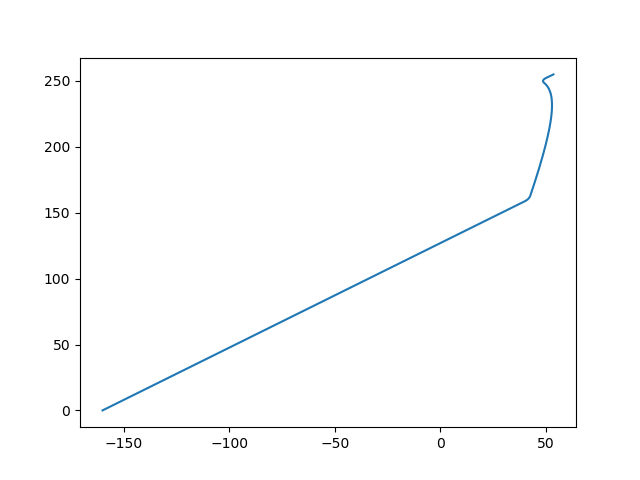

<IPython.core.display.Javascript object>


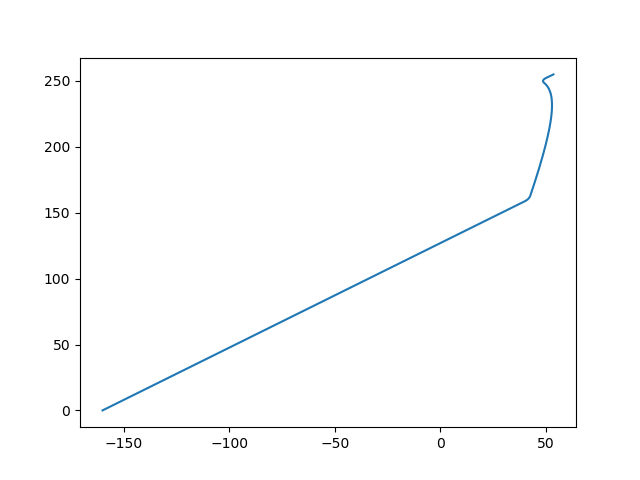

In [4]:
im_1 = image.imread("images/Kluki_-2.jpg")
im_2 = image.imread("images/Kluki_0.jpg")
im_3 = image.imread("images/Kluki_2.jpg")

#print im_paris_1
#imLgray = rgb2gray(imL)
#imRgray = rgb2gray(imR)

Z_1 = im_1.reshape((im_1.shape[0]*im_1.shape[1],3)).T
Z_2 = im_2.reshape((im_2.shape[0]*im_2.shape[1],3)).T
Z_3 = im_3.reshape((im_3.shape[0]*im_3.shape[1],3)).T
#print Z_1.shape
#print Z_2.shape

channel = 2
Z = np.array([Z_1[:,channel], Z_2[:,channel], Z_3[:,channel]])
B = np.array([-2, 0, 2])
l = 1.
zmin = 0
zmax = 255
w = np.ones(256, float)
for i in range(256):
    if i <= (zmin+zmax)/2:
        w[i] = i-zmin
    else:
        w[i] = zmax-i

#w = np.ones(256, float)
#print Z.shape
sol = gsolve(Z, B, l, w)
sol2 = computeResponseCurve(Z, B, l, linearWeight)

fig = plt.figure(1)
plt.plot(sol, range(sol.shape[0]))
fig = plt.figure(2)
plt.plot(sol2, range(sol2.shape[0]))

<IPython.core.display.Javascript object>


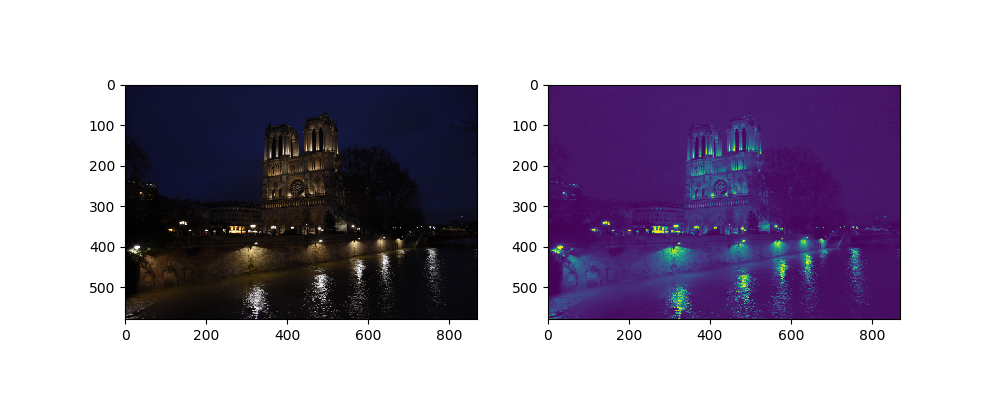

In [5]:
im_paris_1 = image.imread("images/Paris_-1.33.jpg")
im_paris_2 = image.imread("images/Paris_-0.67.jpg")

#print im_paris_1.shape
#print np.max(im_paris_1)
#print np.min(im_paris_1)
m,n,o = im_paris_1.shape
#print im_paris_1
#imLgray = rgb2gray(imL)
#imRgray = rgb2gray(imR)

Z_im_paris_1 = im_paris_1.reshape((im_paris_1.shape[0]*im_paris_1.shape[1],3))
Z_im_paris_2 = im_paris_2.reshape((im_paris_2.shape[0]*im_paris_2.shape[1],3))
#print Z_im_paris_1.shape
#print Z_im_paris_2.shape

Z = np.array([Z_im_paris_1[:,0], Z_im_paris_1[:,0]])
B = np.array([])


plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(im_paris_1)
ax82 = plt.subplot(122)
plt.imshow(Z.T[:,0].reshape((580,870)))
plt.show()